## Import libraries and read the data

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

FIG_SIZE = (12, 6)
FONT_SIZE = "xx-large"
FONT_WEIGHT = "bold"
MARKER_SIZE = 10
LINE_WIDTH = 2
GRID = True

rc = {
    "figure.figsize": FIG_SIZE, "figure.titlesize": FONT_SIZE,
    "axes.labelsize": FONT_SIZE, "axes.labelweight": FONT_WEIGHT,
    "legend.fontsize": FONT_SIZE, "legend.title_fontsize": FONT_SIZE,
    "xtick.labelsize": FONT_SIZE, "ytick.labelsize": FONT_SIZE,
    "lines.markersize": MARKER_SIZE, "lines.linewidth": LINE_WIDTH,
    "axes.grid": GRID,
}

sns.set_theme(style="whitegrid", palette="colorblind", context="paper", rc=rc)

In [2]:
import pandas as pd
from pathlib import Path

NAME = "scalability-cev"
df = pd.read_parquet(f"../results/{NAME}.parquet")

PLOTS_DIR = Path("../plots") / NAME
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# rename versions
df["Version"] = df["Version"].replace({
    "aa": "anti-affinity",
    "pp": "path-protection",
    "rel": "reliability",
})
VERSIONS = df["Version"].unique()

print("Shape", df.shape)
print(df.groupby(["Version", "Output"]).size())


Shape (250, 15)
Version          Output 
all              success    36
                 timeout    14
anti-affinity    success    36
                 timeout    14
path-protection  success    50
plain            success    50
reliability      success    50
dtype: int64


In [3]:
df_success = df[~df['Output'].isin(['no_result', 'timeout'])]
df_timeout = df[df['Output'] == 'timeout']
df_no_result = df[df['Output'] == 'no_result']
df_fail = df[df['Output'].isin(['no_result', 'timeout'])]

# remove all the rows where Nodes is in [16, 32]
# TO_REMOVE = [16, 32]
# df_success = df_success[~df_success['Nodes'].isin(TO_REMOVE)]
# df_fails = df_fails[~df_fails['Nodes'].isin(TO_REMOVE)]

print("SUCCESS", df_success.shape)
print("TIMEOUT", df_timeout.shape)
print("NO RESULT", df_no_result.shape)

SUCCESS (222, 15)
TIMEOUT (28, 15)
NO RESULT (0, 15)


# EXECUTION TIMES

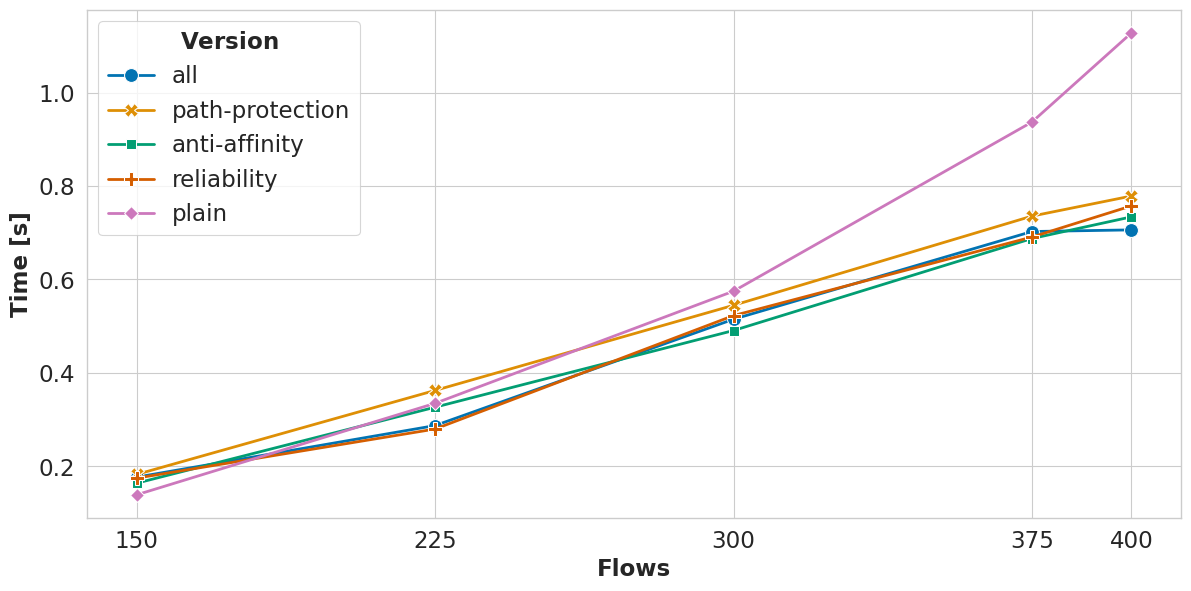

In [4]:
plt.figure(figsize=FIG_SIZE)

sns.lineplot(
    data=df_success,
    x="Flows",
    y="Time",
    hue="Version",
    style="Version",
    errorbar=None,
    dashes=False,
    markers=True,
)

plt.xticks([150, 225, 300, 375, 400])

# plt.title(f"Orion CEV - Execution Times", fontsize=FONT_SIZE)
plt.xlabel("Flows")
plt.ylabel("Time [s]")
plt.legend(title=r"$\bf{Version}$")

plt.tight_layout()
plt.savefig(PLOTS_DIR / "execution-times.pdf", format="pdf", dpi=600)
plt.show()

/tmp/ipykernel_1017247/2062054625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_success.loc[:,"Time_Per_Flow"] = (df_success["Time"] / df_success["Flows"]) * 1000


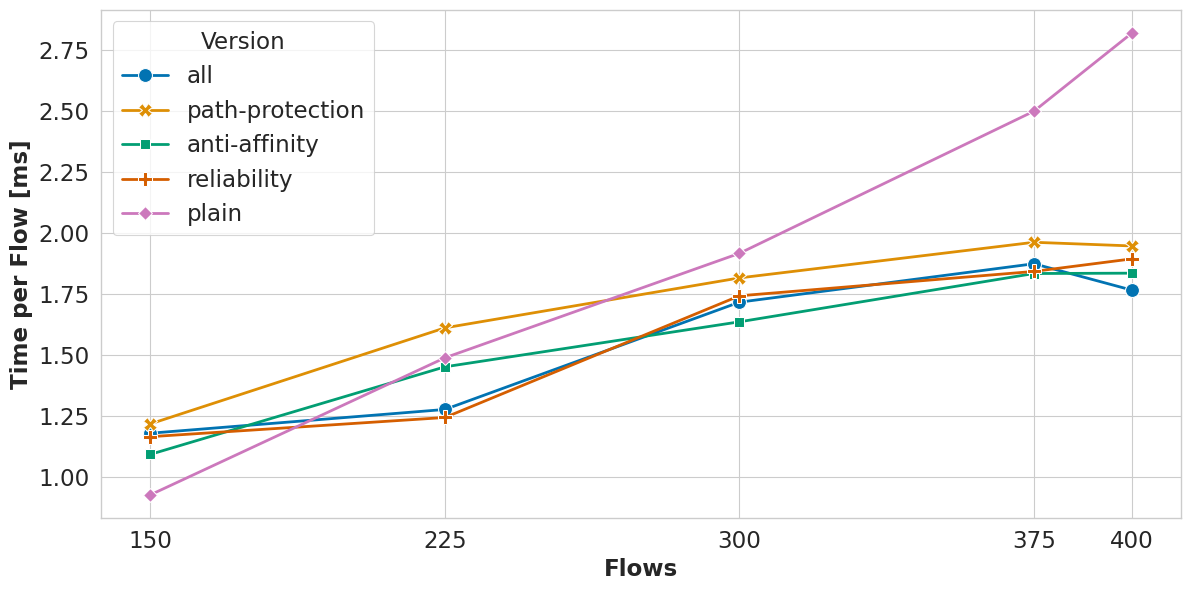

In [5]:
plt.figure(figsize=FIG_SIZE)
df_success.loc[:,"Time_Per_Flow"] = (df_success["Time"] / df_success["Flows"]) * 1000

sns.lineplot(
    data=df_success,
    x="Flows",
    y="Time_Per_Flow",
    hue="Version",
    style="Version",
    errorbar=None,
    markers=True,
    dashes=False,
)

plt.xticks([150, 225, 300, 375, 400])

# plt.title(f"Orion CEV - Time per Flow")
plt.xlabel('Flows')
plt.ylabel('Time per Flow [ms]')
plt.legend(title="Version")

plt.tight_layout()
plt.savefig(PLOTS_DIR / "time-per-flow.pdf", format='pdf', dpi=600)
plt.show()

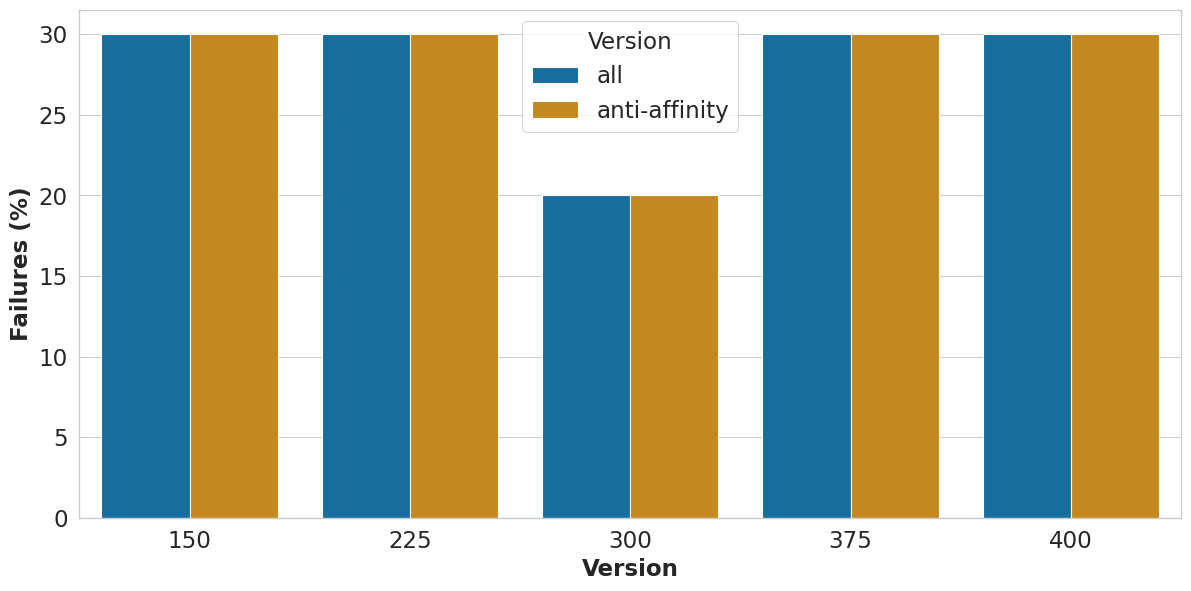

In [6]:
# barplot with number of failures always per version
df_grouped = df_fail.copy()
df_grouped = df_grouped.groupby(["Version", "Flows"]).size().reset_index(name="Count")
df_tot = df.groupby(["Version", "Flows"]).size().reset_index(name="Count")

df_grouped["Percentage"] = df_grouped["Count"] / df_tot["Count"] * 100

sns.barplot(
    data=df_grouped,
    x="Flows",
    y="Percentage",
    hue="Version",
)

# plt.title(f"Orion CEV - Failures")
plt.xlabel('Version')
plt.ylabel('Failures (%)')
plt.legend(title="Version")

plt.tight_layout()
plt.savefig(PLOTS_DIR / "failures.pdf", format='pdf', dpi=600)
plt.show()